In [1]:
import gmaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import g_key
from rossmo_et_ridgway import Rossmo

gmaps.configure(api_key=g_key)

### Notes

* Ridgway notes need to be combined with csv sheets, methinks. 
    * https://docs.google.com/spreadsheets/d/1NHHZEL_3UaFRxgpGcsWyooXnLL-YStYilmb8TJ-JMC4/edit#gid=0
    
* max_distance() in rossmo_et_ridgway needs to exclude outliers, e.g. the max distance for ridgway is 160 miles, which gives a HUGE radius. 
* I also need to review how to scale the heatmap better -- perhaps normalize the output from 0 to 1. 

* Gmaps doc
    * https://jupyter-gmaps.readthedocs.io/en/latest/api.html

In [2]:
body_locations_path = 'resources/Ridgway/body_locations.csv'
disappearances_path = 'resources/Ridgway/disappearances.csv'
ridgway_locations_path = 'resources/Ridgway/ridgway_locations.csv'

df_victims = pd.read_csv(body_locations_path)
df_disappearances = pd.read_csv(disappearances_path)
df_ridgway = pd.read_csv(ridgway_locations_path)

df_disappearances['Coordinates'] = list(zip(df_disappearances['Y'], df_disappearances['X']))

In [3]:
R = Rossmo(df_disappearances['Coordinates'].to_list(), accuracy=100, max_distance=10)

In [4]:
rossmo_results = R.rossmo_formula

In [5]:
df_rossmo_results = pd.DataFrame({'Coordinates': rossmo_results.keys(), 'Score': rossmo_results.values()})

In [6]:
df_rossmo_results['Score Normalized'] = (df_rossmo_results['Score'] - df_rossmo_results['Score'].min()) / (df_rossmo_results['Score'].max() - df_rossmo_results['Score'].min())    
df_rossmo_results

,Coordinates,Score,Score Normalized
0,"(47.10794926376812, -122.05736057521226)",56.633619,0.069006
1,"(47.10794926376812, -122.06345090900918)",56.914033,0.073569
2,"(47.10794926376812, -122.06954124280611)",57.198756,0.078203
3,"(47.10794926376812, -122.07563157660303)",57.487903,0.082909
4,"(47.10794926376812, -122.08172191039996)",57.781592,0.087689
...,...,...,...
9995,"(47.86186073623188, -122.63594228592022)",54.790187,0.039004
9996,"(47.86186073623188, -122.64203261971716)",54.538841,0.034914
9997,"(47.86186073623188, -122.64812295351408)",54.291038,0.030881
9998,"(47.86186073623188, -122.65421328731101)",54.046693,0.026904


In [7]:
greater_than_ninety = df_rossmo_results.loc[
    (df_rossmo_results['Score Normalized'] > 0.50)
]
greater_than_ninety.count()

Coordinates         3662
Score               3662
Score Normalized    3662
dtype: int64

In [8]:
df_rossmo_results['Score Normalized'].describe()

count    10000.000000
mean         0.429269
std          0.216455
min          0.000000
25%          0.253906
50%          0.402954
75%          0.608983
max          1.000000
Name: Score Normalized, dtype: float64

<Figure size 1440x1008 with 0 Axes>

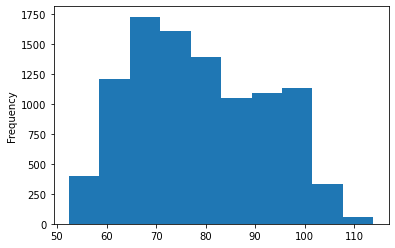

<Figure size 1440x1008 with 0 Axes>

In [9]:
df_rossmo_results['Score'].plot(kind='hist')
plt.figure(figsize=(20,14))

In [10]:
info_box_template = '''
<dl>
<dt><strong>Victim</strong></dt><dd>{Name}</dd>
</dl>
'''
victims_info = [info_box_template.format(**row) for index, row in df_disappearances.iterrows()]

In [12]:
map_center = (np.median(df_disappearances['Y']), np.median(df_disappearances['X']))
fig = gmaps.figure(center=map_center, zoom_level=8)

marker_layer = gmaps.marker_layer(
    df_disappearances['Coordinates'], 
    info_box_content=victims_info
)
heat_layer = gmaps.heatmap_layer(
    df_rossmo_results['Coordinates'],
    weights=df_rossmo_results['Score'],
    dissipating=False,
    opacity=0.4,
    point_radius=0.05
)
# gradient (list of colors, optional) – The color gradient for the heatmap. This must be specified as a list of colors. Google Maps then interpolates linearly between those colors. Colors can be specified as a simple string, e.g. ‘blue’, as an RGB tuple, e.g. (100, 0, 0), or as an RGBA tuple, e.g. (100, 0, 0, 0.5).
fig.add_layer(marker_layer)
fig.add_layer(heat_layer)

fig 

Figure(layout=FigureLayout(height='420px'))